In [164]:
import jupyter_black

jupyter_black.load()

In [165]:
from pyfaidx import Fasta
from pathlib import Path
import pandas as pd
import re

In [166]:
base_path = Path("raw")
path_alpha = base_path / "alpha-CTX-conoserver.fasta"
path_delta = base_path / "delta-CTX-conoserver.fasta"
path_mu = base_path / "mu-CTX-conoserver.fasta"
path_omega = base_path / "omega-CTX-conoserver.fasta"
fasta_paths = [path_alpha, path_delta, path_mu, path_omega]
out_fasta = "CTX.fasta"
out_csv = "CTX.csv"

In [167]:
# duplicate_sction = "stop", "first", "last", "longest", "shortest", "drop"
def read_fasta(fasta_path) -> Fasta:
    return Fasta(
        fasta_path,
        read_long_names=True,
        duplicate_action="first",
        as_raw=True,
        key_function=lambda x: x.strip(),  # re.findall(pattern=r".*? \[(.*)\]", string=x)[0],
    )


headers = {}
for fasta_path in fasta_paths:
    dset_name = fasta_path.stem.split("-")[0]
    headers[dset_name] = set()
    for header, seq in read_fasta(fasta_path=fasta_path).items():
        headers[dset_name].add(header)

<AxesSubplot: >

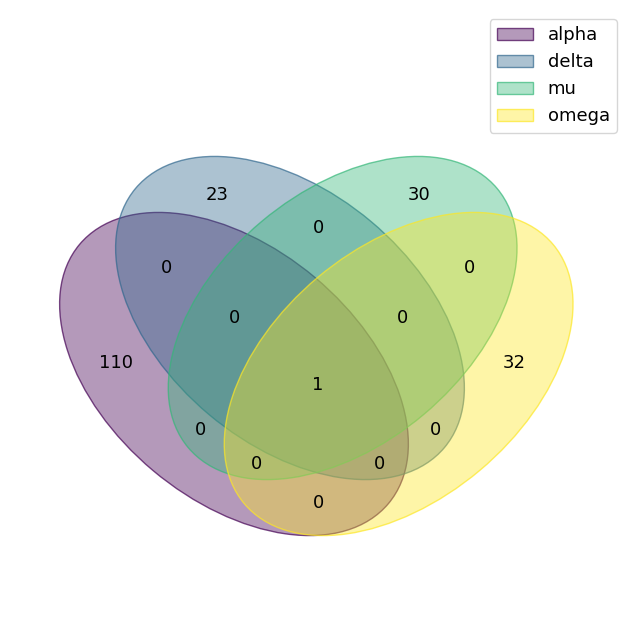

In [168]:
from venn import venn

venn(headers)

In [169]:
duplicate_value = set.intersection(*headers.values())
duplicate_value = list(duplicate_value)[0]
duplicate_value

'SI (Conus striatus (Striated cone)) [P00001]'

- **alpha CTX** contains duplicate of: `SI (Conus striatus (Striated cone)) [P00001]`
- **P00001**: is present in all files as can be seen in Venn diagramm above. Is it the ancestor Protein?
- Number in square brackets do not correspond to UniProt entries (e.g.: P03833 != Pyruvate-flavodoxin oxidoreductase, but == P0CAQ4)
- sequence is only part of the whole protein = a peptide (see [P0CAQ4](https://www.uniprot.org/uniprotkb/P0CAQ4/entry#ptm_processing))

In [170]:
csv_data = []
with open(out_fasta, "w") as out_handler:
    for fasta_path in fasta_paths:
        dset_name = fasta_path.stem.split("-")[0]
        for idx, (header, seq) in enumerate(read_fasta(fasta_path=fasta_path).items()):
            # remov first entry which is always: 'SI (Conus striatus (Striated cone)) [P00001]'
            if idx == 0:
                continue
            csv_data.append(tuple([header, dset_name]))
            out_handler.write(f">{header}\n")
            out_handler.write(f"{seq}\n")

df = pd.DataFrame(data=csv_data, columns=["uid", "ctx_type"])
df.to_csv(path_or_buf=out_csv, index=False)

In [171]:
# clean up .fai files
for fai_file in base_path.glob("*.fai"):
    fai_file.unlink()

## Retrieve whole protein sequences

In [42]:
import re
import requests

In [48]:
def get_uniprot_fasta(organism: str, prot_name: str) -> str:
    # organism = "Conus striatus (Striated cone)"

    base = "https://rest.uniprot.org/uniprotkb/search?query="

    # organism_name = "Conus achatinus"
    # prot_name = "Ac1.1a"
    query = f"(organism_name:\"{organism}\") AND (protein_name:{prot_name})"
    data_format = "&format=fasta"
    url = f"{base}{query}{data_format}"
    results = requests.get(url).text

    if results.count(">") != 1:
        print(f"not one entry found for\norganism: {organism}\nprot_name: {prot_name}")
        print(url)
    return results

In [49]:
def parse_uniprot(uniprot_result: str):
    seq = []
    for line in uniprot_result.split("\n"):
        if line.startswith(">"):
            header = line[1:]
        else:
            seq.append(line)
    return header, seq

In [ ]:
with open(out_fasta, "w") as out_handler:
    for fasta_path in fasta_paths:
        dset_name = fasta_path.stem.split("-")[0]
        for idx, (header, seq) in enumerate(read_fasta(fasta_path=fasta_path).items()):
            # remov first entry which is always: 'SI (Conus striatus (Striated cone)) [P00001]'
            if idx == 0:
                continue
            try:
                prot_name, organism = re.match(
                    pattern=r"(.*) \((.*)\) \[.*\]", string=header
                ).groups()
            except AttributeError:
                print(header)
                raise
            print(prot_name, organism)
            # uniprot_fasta = get_uniprot_fasta(organism=organism, prot_name=prot_name)
            # new_header, new_seq = parse_uniprot(uniprot_result=uniprot_fasta)
            # out_handler.write(f">{new_header}\n")
            # out_handler.write(f"{new_seq}\n")

## Data from UniProt
- Get all data that have links to `ConoServer` : (database:conoserver)
- Fragments == False: AND (fragment:false)
- [url](https://www.uniprot.org/uniprotkb?query=%28database%3Aconoserver%29%20AND%20%28fragment%3Afalse%29) and final query: `(database:conoserver) AND (fragment:false)`

In [97]:
fasta_path = Path("raw/CTX_uniprot.fasta")

In [ ]:
header_pattern = r"^(\w{2})\|(\w{6,10})\|(\w{3,16}) (.+?) OS=(.+?) OX=(\d{1,7}) (?:GN=(\w*?) )?PE=(\d) SV=(\d)+$"
prot_pattern = r"^(?:(\S+?)-)?[cC]onotoxin(?:-like)? (.+?)(?: \(Fragment\))?$"
for header, seq in Fasta(fasta_path, read_long_names=True).items():
    groups = re.match(pattern=header_pattern, string=header).groups()
    uid, prot_name, organism = [groups[idx] for idx in [1, 3, 4]]
    match = re.match(pattern=prot_pattern, string=prot_name)
    if match is not None:
        try:
            ctx_type, prot_id = match.groups()
        except ValueError:
            print(match.groups())
            raise
        ctx_type = ctx_type if ctx_type is not None else "conotoxin"
    else:
        ctx_type = "other"
    # remove sequences not starting with M
    if str(seq).startswith("M"):
        continue
    else:
        print(header)

## Data from ConoServer
Download Fasta file on 04.12.2022: http://www.conoserver.org/index.php?page=download
**Note:** the format of the headers in the FASTA file is:
- for proteins: conoserver identifier|name|organism|protein type|toxin class|gene superfamily|cysteine framework|pharmacological family|evidence
- for nucleic acids: conoserver identifier|name|organism

In [4]:
import pandas as pd
from pyfaidx import Fasta

conoserver_fasta_path = "raw/conoserver_protein.fa"
out_fasta_all = "conoserver.fasta"
out_fasta_precurser = "conoserver_precursor.fasta"
out_csv_all = "conoserver.csv"
out_csv_precurser = "conoserver_precursor.csv"

In [47]:
data = []
flage = False
for header, seq in Fasta(conoserver_fasta_path, read_long_names=True).items():
    seq = str(seq)
    if seq:
        # header after an entry without a sequence has two ">"
        # one is remove by pyfaidx the other manually here
        if header.startswith(">"):
            header = header[1:]
        # most X at the ending indicate a `C-term amidation`. Therefore, remove
        if seq.endswith("X") or seq.endswith("x"):
            seq = seq[:-1]
        data.append(tuple([header, seq]))

df = pd.DataFrame(data=data, columns=["header", "seq"])

In [48]:
header_col_names = [
    "conoserver_uid",
    "name",
    "organism",
    "prot_type",
    "toxin_class",
    "gene_superfamily",
    "cystein_framework",
    "pharmacological_family",
    "evidence",
]
df[header_col_names] = df["header"].str.split("|", expand=True)
df = df.loc[df["prot_type"] != "Synthetic"]
# df.drop(labels=["header"], axis=1, inplace=True)
df.head(2)

,header,seq,conoserver_uid,name,organism,prot_type,toxin_class,gene_superfamily,cystein_framework,pharmacological_family,evidence
0,P00001|SI|Conus striatus|Wild type|conotoxin|A...,ICCNPACGPKYSC,P00001,SI,Conus striatus,Wild type,conotoxin,A superfamily,alpha conotoxin,I,protein level
1,P00006|OmIA|Conus omaria|Wild type|conotoxin|A...,GCCSHPACNVNNPHICG,P00006,OmIA,Conus omaria,Wild type,conotoxin,A superfamily,alpha conotoxin,I,protein level


In [46]:
# save complete ConoServer data
with open(out_fasta_all, "w") as out:
    for idx, data in df.iterrows():
        out.write(f">{data['conoserver_uid']}\n")
        out.write(f"{data['seq']}\n")
df_all = df.drop(labels=["seq", "name"], axis=1)
df_all = df_all.rename(
    mapper={"conoserver_uid": "mapped_id", "header": "original_id"}, axis=1
)
# reorder columns
cols = df_all.columns.to_list()
cols = [cols[1]] + [cols[0]] + cols[2:]
df_all = df_all[cols]
df_all.to_csv(path_or_buf=out_csv_all, index=False)

In [30]:
# filter for Precursor data (aka. entire protein sequence)
df_precursor = df.loc[df["prot_type"] == "Precursor"].reset_index(drop=True)
with open(out_fasta_precurser, "w") as out:
    for idx, data in df_precursor.iterrows():
        out.write(f">{data['conoserver_uid']}\n")
        out.write(f"{data['seq']}\n")
df_precursor = df_precursor.drop(labels=["seq", "name"], axis=1)
df_precursor = df_precursor.rename(
    mapper={"conoserver_uid": "mapped_id", "header": "original_id"}, axis=1
)
# reorder columns
cols = df_precursor.columns.to_list()
cols = [cols[1]] + [cols[0]] + cols[2:]
df_precursor = df_precursor[cols]
df_precursor.to_csv(path_or_buf=out_csv_precurser, index=False)

In [27]:
import h5py
import numpy as np

h5_path = "conoserver_precursor_esm2.h5"
with h5py.File(h5_path, "r") as hdf:
    for k, v in hdf.items():
        v = np.array(v)
        if sum(np.isnan(v)) != 0:
            print(k, v)
            # break

P07185 [nan nan nan ... nan nan nan]
